In [1]:
import sys, os, glob
import pypillometry as pp
import pandas as pd
import numpy as np
import pylab as plt
import scipy.io
import scipy.signal

os.environ['NUMEXPR_MAX_THREADS'] = '4'
os.environ['NUMEXPR_NUM_THREADS'] = '2'
import numexpr as ne

In [11]:
import matplotlib.pyplot
# function to apply bandpass filter
def bandPass(signal):
    fs = 1200.0
    lowcut = 0.1
    highcut = 40.0

    nyq = 0.5*fs
    low = lowcut/nyq
    high = highcut/nyq

    order = 2

    b,a = scipy.signal.butter(order, [low, high], 'bandpass', output='ba') # analog=True or analog=False
    y = scipy.signal.filtfilt(b, a, signal, axis=-1)
    
    # trying to keep signal at value location
    # zi = scipy.signal.lfilter_zi(b, a); 
    # y, zo = scipy.signal.lfilter(b, a, signal, zi=zi*signal[0])
    # y = scipy.signal.lfilter(b, a, signal, axis=0, zi=None)
    
    return y

# function to load a mat file and store it in pd dataframe
def load_mat(matLoc, checkIntPerc = False, data_name = 'Data'):

    # vars for voltage correction
    maxvolt = 5
    minvolt = -5
    
    mat = scipy.io.loadmat(matLoc)

    concat_df = pd.DataFrame(data=[])

    interpol_vals = [0]*24
    raw_vals = [0]*24
    
    for b in range(24):
        df = pd.DataFrame(data=pd.Series(mat['tskData'][0][0][7][0][b][0]), columns=['time'])
        df['pupil'] = mat['tskData'][0][0][6][0][b][3]    
        df['block'] = b+1

        # interpolate voltages to sizes
        df.pupil = (df.pupil-minvolt)/(maxvolt-minvolt)
        
        # due to continuous values, replace mising data with 0
        df['pupil'].mask(df['pupil'] <= 0.01, 0, inplace=True)

        # apply bandpass filter
        # df.pupil = bandPass(df.pupil)

        ## ToDo check for percentage of interpolated data
        if checkIntPerc:
            # print(b)
            int_d, raw_d = int_perc_check(df)
            interpol_vals[b] = int_d
            raw_vals[b] = raw_d

            if ((int_d/raw_d)<=0.3): # see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6535748/
                # concatenate over experimental blocks
                concat_df = pd.concat([concat_df, df], ignore_index=True)
        else:
            concat_df = pd.concat([concat_df, df], ignore_index=True)
        
    # print(interpol_vals) # print values 
    
    # Pass the x and y cordinates of the bars to the
    # function. The label argument gives a label to the data.
    calc_data = [0]*24
    for i in range(24):
        calc_data[i] = interpol_vals[i]/raw_vals[i]

    # plot:
    matplotlib.pyplot.bar(range(1,25),calc_data, label=data_name)
    matplotlib.pyplot.legend()
    
    # The following commands add labels to our figure.
    matplotlib.pyplot.xlabel('Blocks')
    matplotlib.pyplot.ylabel('percent')
    matplotlib.pyplot.axhline(0.3, color='red')
    matplotlib.pyplot.title('Interpolated data in blocks from ' + data_name)
    matplotlib.pyplot.savefig(datapath+'pp_dfs/pics_interpolated/'+data_name+'.png', dpi=400)    
    matplotlib.pyplot.show()

    return concat_df


## function to check for percentage of interpolated data (for plotting histogram later)
def int_perc_check(pp_data):
    data = pp.PupilData(pp_data.pupil, time=pp_data.time, name='test', sampling_rate=1200, fill_time_discontinuities=False)
    pp_preprocd = data.blinks_detect(winsize = 150,min_duration=10,strategies=["zero","velocity"],
                       vel_onset=-0, vel_offset=0,
                       min_onset_len=2, min_offset_len=2)\
                .blinks_merge(distance=100)\
                .blinks_interpolate(winsize=10, margin=(50,150), vel_onset=-0, vel_offset=0)
                #.blinks_interp_mahot(winsize=10, margin=(50,150), vel_onset=-0, vel_offset=0) ## currently breaks 

    n_inter = sum(pp_preprocd.interpolated_mask) # number of interpolated points
    n_raw = len(pp_preprocd.sy) # number of raw datapoints
    # print(str(n_inter/n_raw)) # print percent of interpolated points
    return[n_inter,n_raw]

# function to load in multiple datasets
def load_PP_data(dataLs, saveBool = True, checkIntPerc = False):

    datasets = [None]*len(dataLs)
    
    for idx,d in enumerate(dataLs):
        # load data from mat file
        pupil_df = load_mat(datapath+d+'/main/'+'main_eye_'+d+'.mat', checkIntPerc, d)

        # load additional behavioural data from csv
        behav_df =pd.read_csv(datapath+d+'/main/'+'main_behdf_'+d+'.csv')


        if pupil_df.empty != True:
            # create pupilData based on combination of pupil and behavioural data
            pp_Data = pp.PupilData(pupil_df.pupil, time=pupil_df.time, name=d, sampling_rate=1200, fill_time_discontinuities=False ,event_onsets=behav_df.timing_meg, event_labels=behav_df.block) # standard fill_time_discontinuities=True
    
        # save PupilData in array
        datasets[idx] = pp_Data

        # save some ram space
        pp_Data = []

    if saveBool:
        # save pupilData datasets on disk
        for ds in datasets:
            if ds != []:
                fname=os.path.join(datapath+'pp_dfs/', ds.name+".pd")
                ds.write_file(fname)
    
    return datasets

## Run to build pd files

In [73]:
test3[0].tx

array([-53368.14008333, -53368.13925   , -53368.13841667, ...,
       -49586.92175   , -49586.92091667, -49586.92008333])

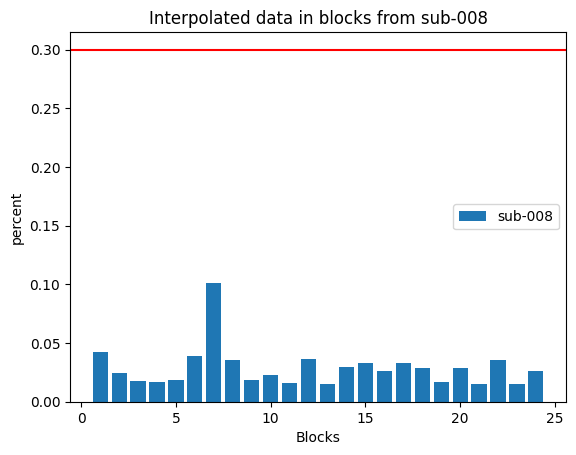

[PupilData(sub-008, 384.7MiB):
  n                 : 3598118
  nmiss             : 36085
  perc_miss         : 1.0028853973104828
  nevents           : 11520
  nblinks           : 0
  ninterpolated     : 0
  blinks_per_min    : 0.0
  fs                : 1200
  duration_minutes  : 49.97386111111112
  start_min         : -0.8894690013888888
  end_min           : -0.8264486680555555
  baseline_estimated: False
  response_estimated: False
  History:
  *]

In [63]:
test3 = load_PP_data(['sub-008'], False, True)
test3

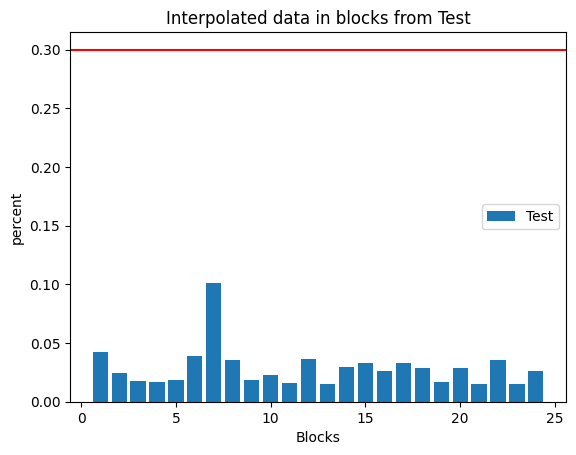

,time,pupil,block
0,-53368.140083,0.157124,1
1,-53368.139250,0.156981,1
2,-53368.138417,0.156839,1
3,-53368.137583,0.156560,1
4,-53368.136750,0.156225,1
...,...,...,...
3598113,-49586.923417,0.176259,24
3598114,-49586.922583,0.176185,24
3598115,-49586.921750,0.176235,24
3598116,-49586.920917,0.176360,24


In [62]:
test2 = load_mat(datapath+'sub-008'+'/main/'+'main_eye_sub-008.mat', True,'Test')
test2

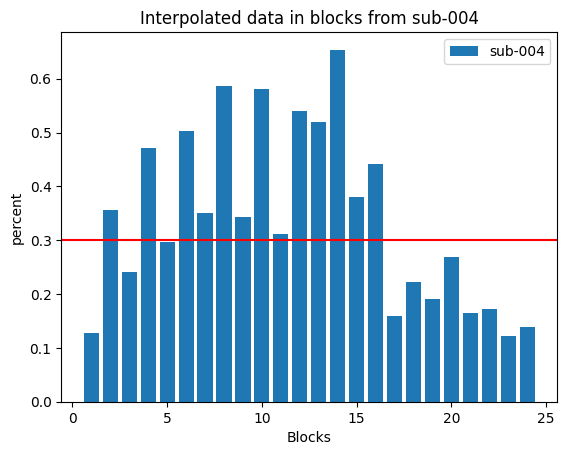

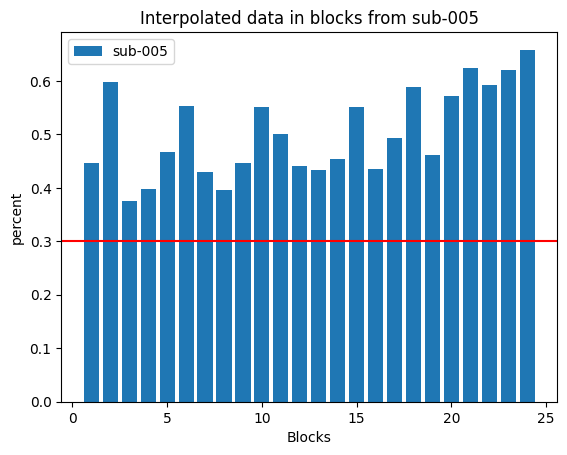

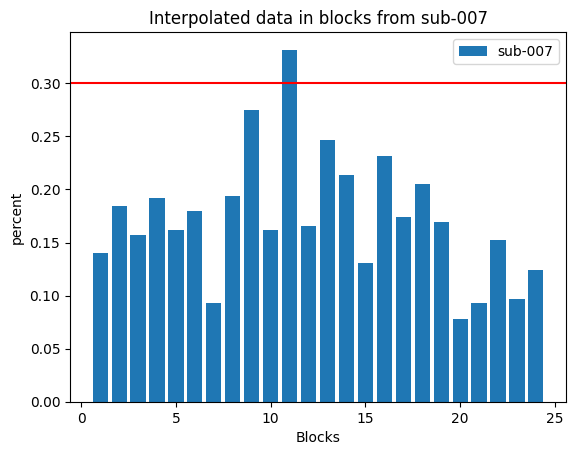

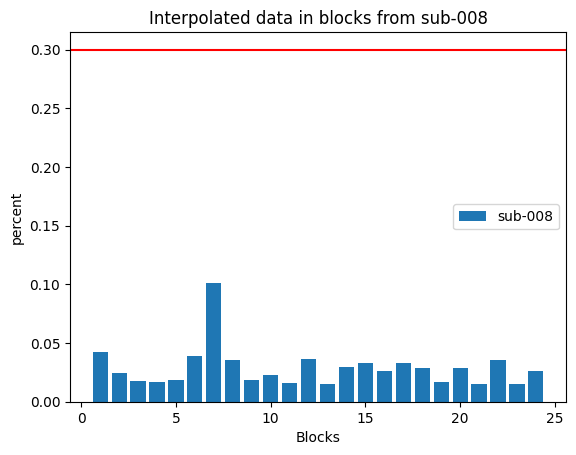

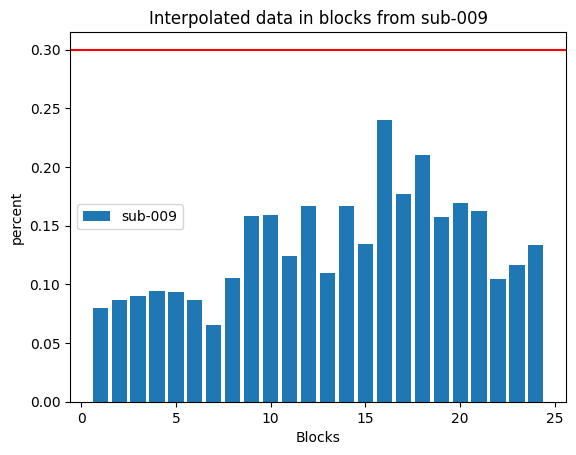

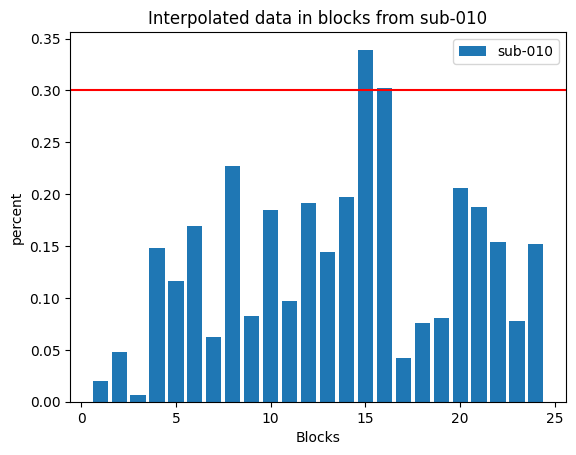

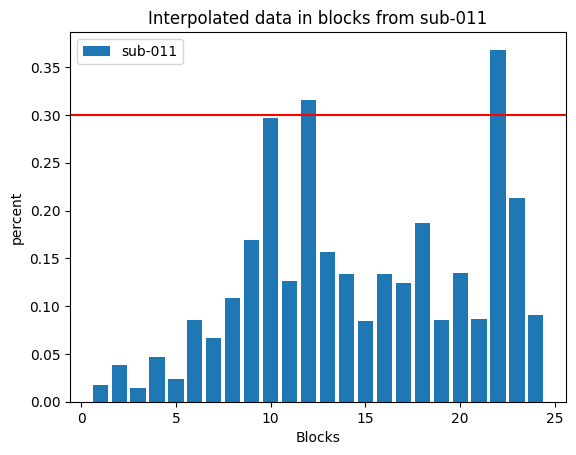

In [12]:
datapath = '/Users/scanlab/Documents/internship_luca/pupildata/'

data2use = ['sub-004', 'sub-005', 'sub-007', 'sub-008', 'sub-009', 'sub-010', 'sub-011']#, 'sub-013', 'sub-014'] # ['sub-004', 'sub-010']


data = load_PP_data(data2use, True, True)
# datapath = '/home/luca/Documents/internship/pupildata/sub-004/main/'

### Testing of funcitons below

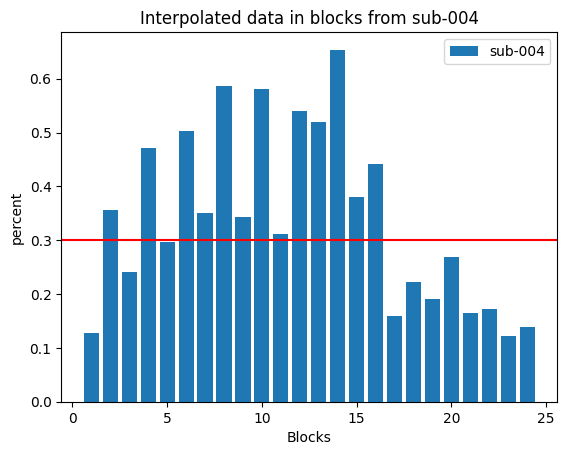

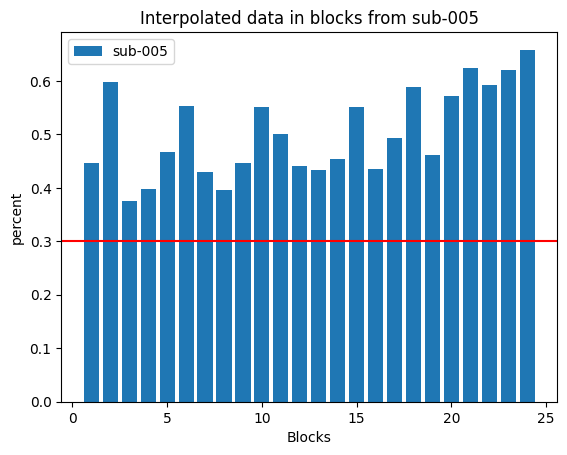

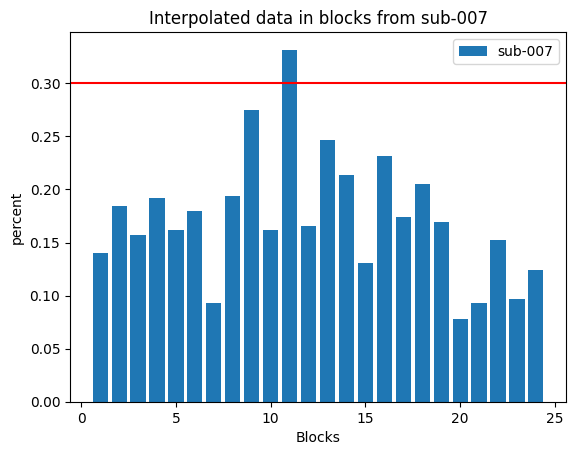

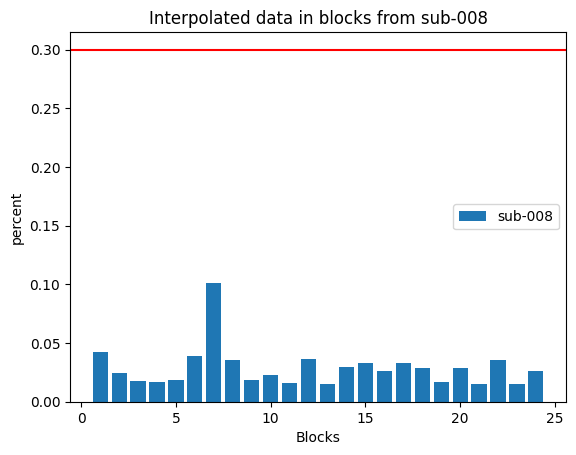

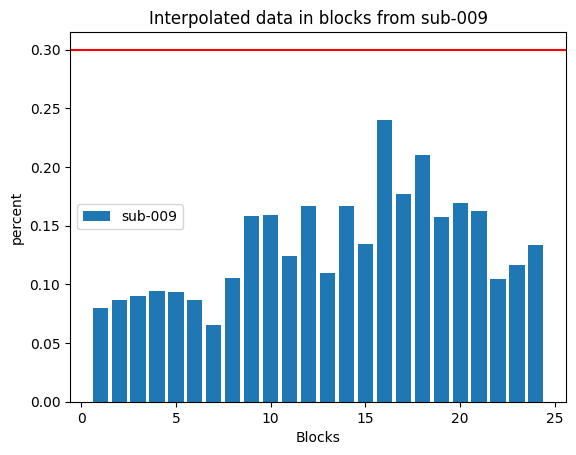

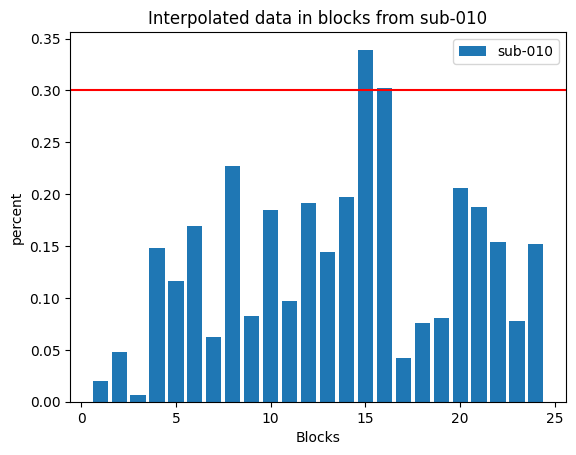

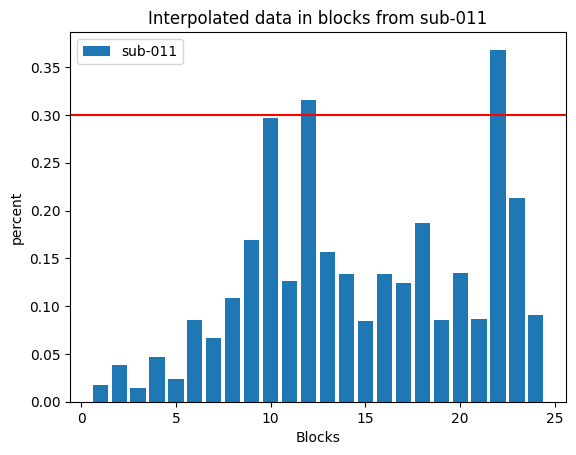

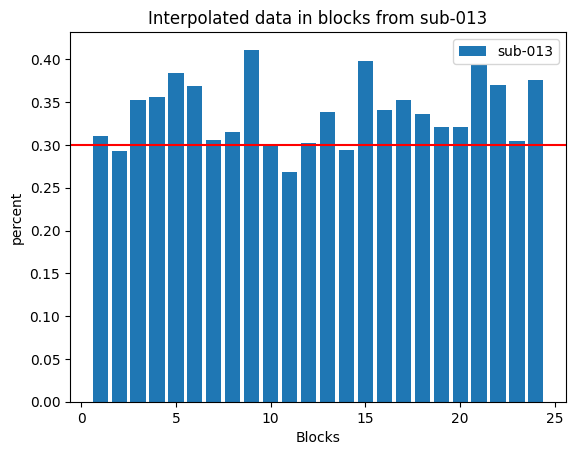

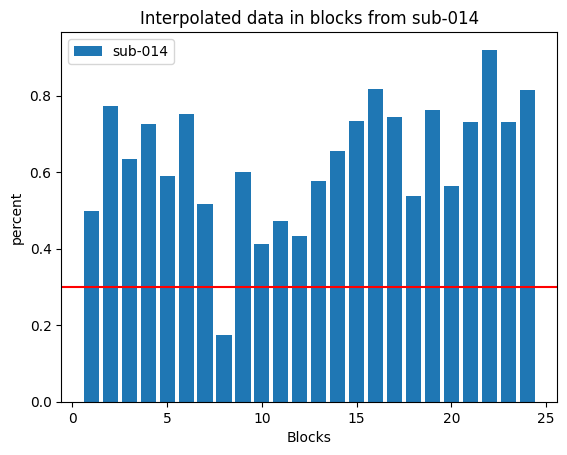

In [56]:
files2Test = ['sub-004','sub-005','sub-007','sub-008','sub-009','sub-010','sub-011','sub-013','sub-014']
datapath = '/Users/scanlab/Documents/internship_luca/pupildata/'

for nM in files2Test:
    data_file = load_mat(datapath+nM+'/main/'+'main_eye_'+nM+'.mat', True, nM)
    data_file.to_csv('/Users/scanlab/Documents/internship_luca/pupildata/pp_dfs/raw/'+nM+'.csv') 
    # print(data_file)

In [14]:
datapath = '/home/luca/Documents/internship/pupildata/'
fileName = 'sub-009'
behav_df =pd.read_csv(datapath+fileName+'/main/'+'main_behdf_'+fileName+'.csv')
behav_df

,frequencies,frequencies_oct,timing,timing_offset,run,block,segment,center_freq_a,center_freq_b,center_freq_a_oct,center_freq_b_oct,probability_a,probability_b,stimulus,timing_meg,timing_offset_meg
0,767.133223,9.583333,2883.717139,2883.919127,1.0,1.0,1.0,834.255221,2322.505710,9.704345,11.181466,0.950000,0.050000,1,-155129.233106,-155129.031117
1,724.077344,9.500000,2883.967139,2884.169498,1.0,1.0,1.0,834.255221,2322.505710,9.704345,11.181466,0.950000,0.050000,2,-155128.983106,-155128.780747
2,608.874043,9.250000,2884.217139,2884.419124,1.0,1.0,1.0,834.255221,2322.505710,9.704345,11.181466,0.950000,0.050000,3,-155128.733106,-155128.531121
3,1024.000000,10.000000,2884.467139,2884.669145,1.0,1.0,1.0,834.255221,2322.505710,9.704345,11.181466,0.950000,0.050000,4,-155128.483106,-155128.281099
4,406.374669,8.666667,2884.717139,2884.919515,1.0,1.0,1.0,834.255221,2322.505710,9.704345,11.181466,0.950000,0.050000,5,-155128.233106,-155128.030730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11515,724.077344,9.500000,6436.175863,6436.377848,12.0,24.0,10.0,645.854171,1798.010924,9.335065,10.812186,0.891211,0.108789,11516,-151576.774382,-151576.572396
11516,767.133223,9.583333,6436.425863,6436.627876,12.0,24.0,10.0,645.854171,1798.010924,9.335065,10.812186,0.891211,0.108789,11517,-151576.524382,-151576.322368
11517,724.077344,9.500000,6436.675863,6436.877350,12.0,24.0,10.0,645.854171,1798.010924,9.335065,10.812186,0.891211,0.108789,11518,-151576.274382,-151576.072894
11518,861.077929,9.750000,6436.925863,6437.128039,12.0,24.0,10.0,645.854171,1798.010924,9.335065,10.812186,0.891211,0.108789,11519,-151576.024382,-151575.822205


# Preprocessing

In [78]:
datapath = '/Users/scanlab/Documents/internship_luca/pupildata/pp_dfs/'

# load all filenames in `datapath` that end with `.pd`
pd_files=[fname for fname in os.listdir(datapath) if fname.endswith(".pd")]
datasets=[]
for fname in pd_files:
    fname=os.path.join(datapath, fname)
    d=pp.PupilData.from_file(fname)
    datasets.append(d)

In [79]:
# load all raw datasets
exclude=['sub-001','sub-002','sub-012', 'sub-013', 'sub-014'] ## these subject did not have usable data

# datasets are stored in a dict structure
datasets={d.name.split("_")[0]:d for d in datasets if d.name not in exclude}

In [82]:
# specify pre-processing parameters per subj
default_param={"min_duration":10,    # min duration of a blink
               "min_offset_len":2,   # offset/onset-length for blink-detection
               "min_onset_len":3,
               "vel_onset":-0,       # velocity thresholds for onset and offset
               "vel_offset":0,
               "strategies":["zero","velocity"],  # strategies for blink-detection
              "distance":100,        # minimum distance between two blinks
              "margin":(50,150),     # margins for Mahot algorithm
              "cutoff":5,            # lowpass-filter cutoff (Hz)
              "downsample":50}       # downsample to XX Hz

# create dict with parameters per subject
# all subjects get the same set of default parameters initially
params={subj:default_param.copy() for subj in datasets.keys()}

In [83]:
## fine-tuning of the parameters per subject
# subj = "sub-001"
# No pupil data!
# IndexError: index -1 is out of bounds for axis 0 with size 0
# subj = "sub-002"
# No pupil data!
# IndexError: index -1 is out of bounds for axis 0 with size 0
subj = "sub-004"
# Writes File
subj = "sub-005"
# Writes File
subj = "sub-007"
# Writes File
subj = "sub-008"
# Writes File
subj = "sub-009"
# Writes File
subj = "sub-010"
# Writes File
#params[subj]["vel_onset"]=-10
subj = "sub-011"
# Writes File
# subj = "sub-012"
# No pupil data!
# IndexError: index -1 is out of bounds for axis 0 with size 0
subj = "sub-013"
# Writes File
subj = "sub-014"
# Writes File


## notes for preprocessing
#### subject 4
- spike at -2.282
- spike at -2.273
- spike at -2.266
- spike at -2.256
- spike at -2.236
- spike at -2.225
#### subject 5
- very noisy
- many spikes in beginning & end
- data of blocks blur together
#### subject 7
- clean data with some eyeblinks
- interpolated data seems quite good
#### subject 8
- clean data
- not many eyeblinks in the first place
- => therefore: some noise in interpolated data might still be existend
#### subject 9
- overal quite clean data
- spike at -2.565
- spike at -2.548
#### subject 10
- clean data, little blinks/artefacts
- spike at 0.1525
- spike at 0.161
- spike at end (0.2)
#### subject 11
- very clean, little eyeblinks/artefacts
- many spikes between 0,27 to 0.28
#### subject 13
- many eye blinks
- start from 0?
- no visible spikes
#### subject 14
- moderate number of eyeblinks
- much missing data!
- interpolated data makes many "jumpes"
- very noisy


sub-008
sub-009
sub-007
sub-010
sub-004
sub-011


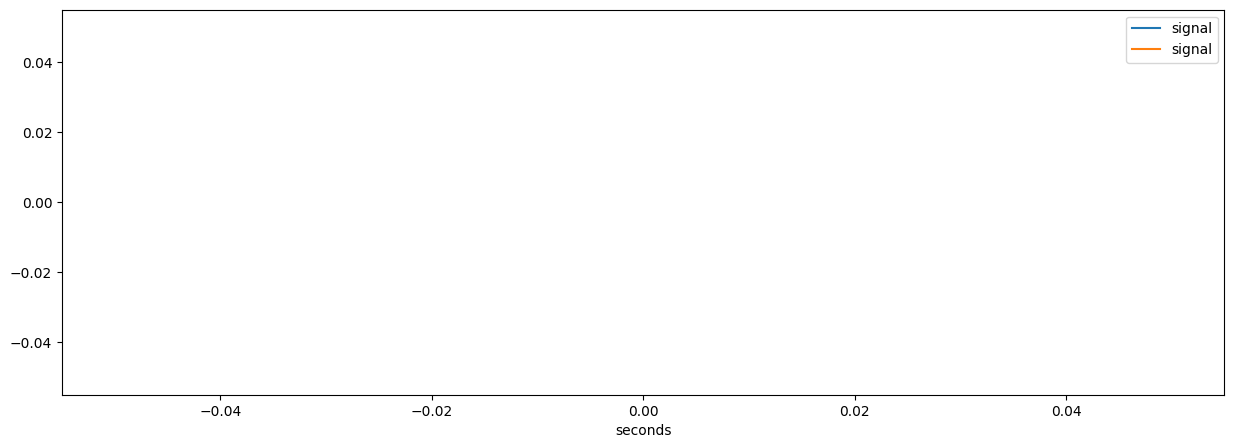

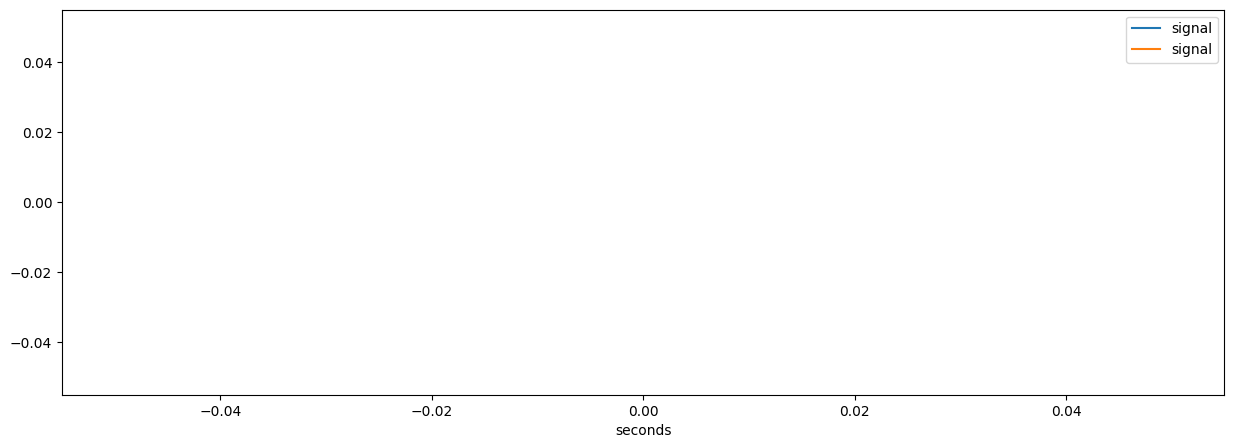

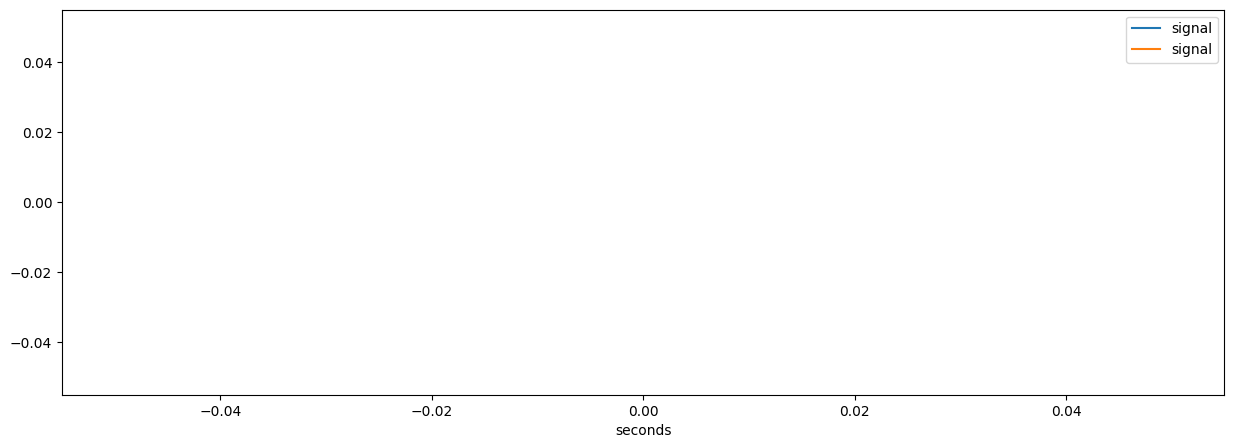

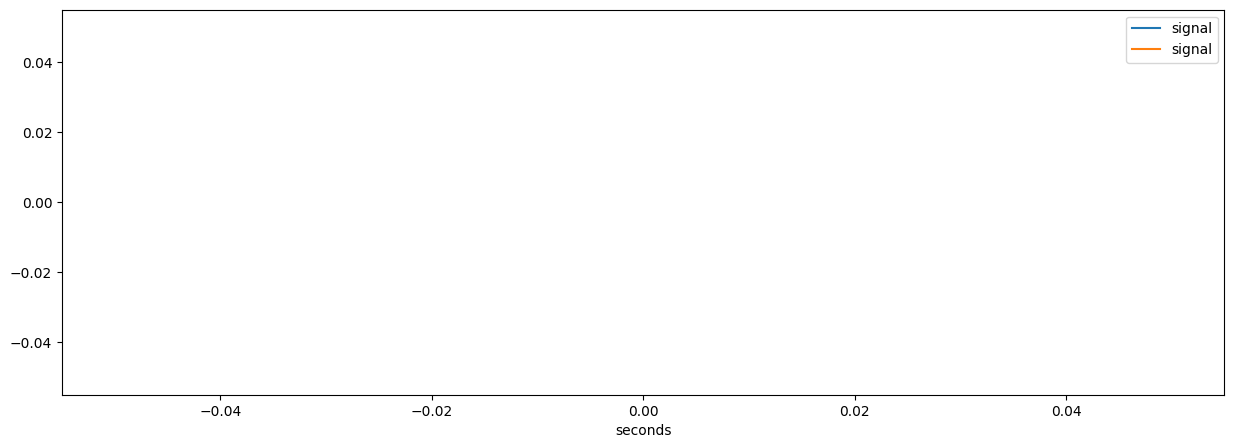

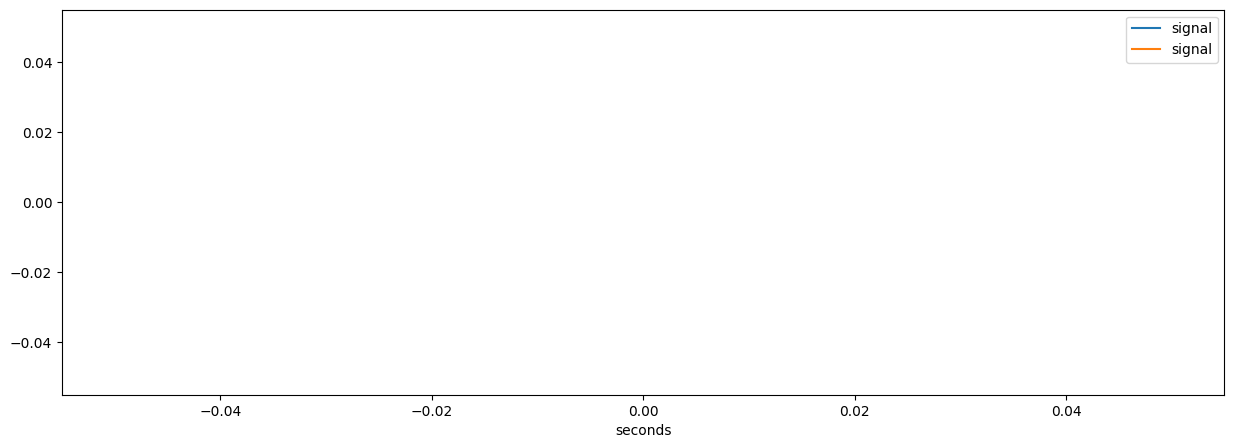

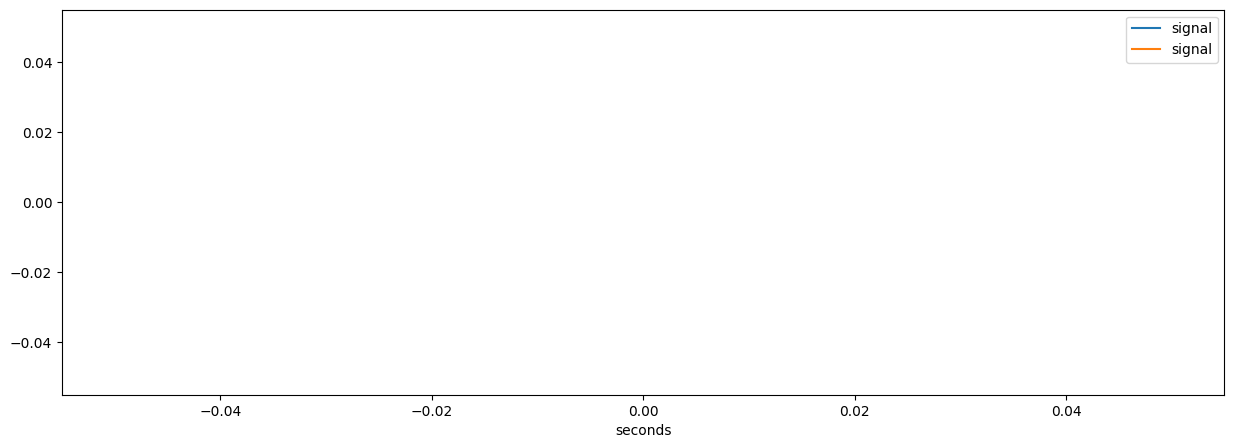

In [84]:
## run pre-proc pipeline on all subjects and produce PDFs for inspection
# add downsampling?
preprocs={}
# go trough datasets
for subj,d in datasets.items():
    print(d.name)
    pars=params[subj]
    # apply predefined parameters
    # dp=d.reset_time()\
    dp=d.downsample(400)\
            .blinks_detect(winsize = 150,min_duration=pars["min_duration"],strategies=pars["strategies"],
                       vel_onset=pars["vel_onset"], vel_offset=pars["vel_offset"],
                       min_onset_len=pars["min_onset_len"], min_offset_len=pars["min_offset_len"])\
            .blinks_merge(distance=pars["distance"])\
            .blinks_interp_mahot(margin=pars["margin"], vel_onset=pars["vel_onset"], vel_offset=pars["vel_offset"])\
            .lowpass_filter(cutoff=pars["cutoff"]).downsample(40)
    # plot preprocessed data and save as pdf or png
    # d.reset_time(inplace=True)
    plt.figure(figsize=(15,5))
    d.plot((0,0.5), highlight_blinks=False)
    dp.plot((0,0.5), highlight_blinks=False)
    plt.savefig('/Users/scanlab/Documents/internship_luca/pupildata/pp_dfs/pics/'+subj+'.png')
    # d.plot_segments(overlay=dp, pdffile="/home/luca/Documents/internship/pupildata/pp_dfs/pics/%s.pdf"%d.name,figsize=(40,6), ylim=(dp.sy.min(), dp.sy.max()))
    # save preprocessed dataset
    preprocs[subj]=dp

In [88]:
# save data in individual csv files
os.makedirs('/Users/scanlab/Documents/internship_luca/pupildata/pp_dfs/preprocs/', exist_ok=True)  
for subj, d in preprocs.items():
    if subj not in exclude:
        # print(d.sy)
        prepro_df =  pd.DataFrame(d.sy, columns = ['pupil'])
        prepro_df['time'] =  d.tx
        # prepro_df['block'] =  d.event_labels
        prepro_df.to_csv('/Users/scanlab/Documents/internship_luca/pupildata/pp_dfs/preprocs/'+subj+'.csv') 
        i+=1

In [54]:
## save data in pd dataframe
data2exp = [0]*9
name2exp = [0]*9
i = 0
for subj, d in preprocs.items():
    if subj not in exclude:
        # print(d.sy)
        data2exp[i] = d.sy
        name2exp[i] = subj
        i+=1

prepro_df =  pd.DataFrame(preprocs['sub-008'].tx, columns = ['time'])

for enum,subj in enumerate(name2exp):
    prepro_df[subj] = data2exp[enum]
prepro_df

# # save to csv
# os.makedirs('/home/luca/Documents/internship/pupildata/pp_dfs/preprocs/', exist_ok=True)  
# prepro_df.to_csv('/home/luca/Documents/internship/pupildata/pp_dfs/preprocs/out.csv') 

ValueError: Length of values (114941) does not match length of index (119938)

In [ ]:
## write final prep-processed files for further analysis
exclude_preproc = []
pickle
# save preprocessed datasets
preprocs={subj:d for subj,d in preprocs.items() if subj not in exclude_preproc}

pp.pd_write_pickle(preprocs, "/home/luca/Documents/internship/pupildata/pp_dfs/preprocs/eye_preproc.pd")

# Code testing below! 

## Test bandpass filter

In [1]:
## play around with bandpass filter

d2f = test.pupil[1:80000]
time = test.time[1:80000]

plt.plot(time, d2f)

NameError: name 'test' is not defined

In [ ]:
filtred_data = bandPass(d2f)
plt.plot(time, filtred_data)

In [ ]:
# calculaing percentage of interpolated data - deprecated
n_raw = [0] * len(preprocs)
n_int = [0] * len(preprocs)
n_sub = [0] * len(preprocs) # temp
count = 0
for subj,d in preprocs.items():
    # calculate % for each block
    n_int_block = [0]*24
    n_raw_block = [0]*24
    b_start = 0
    # go trough data in each block
    for b in range(1,25):
        n_raw_block[b]=d.sy[b_start:b*149920]
        n_int_block[b]=sum(d.interpolated_mask[b_start:b*149920])
        b_start = b*149920
    
    n_sub[count] = subj
    n_raw[count] = n_raw_block #len(d.sy)
    n_int[count] = n_int_block #sum(d.interpolated_mask)
    # print(n_sub[count]+": Precentage of interpolated data: "+str(n_int[count]/n_raw[count])+" %")
    count = count+1
    
# ToDo: if < XX%, then exclude data/block from the further analysis

# Notes2do
- calculate percentage of interpolated data per block per participant -> 9*24 array -> plot historgram
    - done!
- behavioural data, create surprise values -> measure of surprise -> start exploring real pupil response function
    - plot mean response function to start of segment